In [1]:
import os
import time
import sys
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import motornet as mn
from tqdm import tqdm

print('All packages imported.')
print('pytorch version: ' + th.__version__)
print('numpy version: ' + np.__version__)
print('motornet version: ' + mn.__version__)

All packages imported.
pytorch version: 2.2.0.dev20231105
numpy version: 1.24.1
motornet version: 0.2.0


In [2]:
effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.RigidTendonHillMuscle())
env = mn.environment.RandomTargetReach(effector=effector, max_ep_duration=1.)

In [3]:
class Policy(th.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, device):
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = 1
        
        self.gru = th.nn.GRU(input_dim, hidden_dim, 1, batch_first=True)
        self.fc = th.nn.Linear(hidden_dim, output_dim)
        self.sigmoid = th.nn.Sigmoid()

        # the default initialization in torch isn't ideal
        for name, param in self.named_parameters():
            if name == "gru.weight_ih_l0":
                th.nn.init.xavier_uniform_(param)
            elif name == "gru.weight_hh_l0":
                th.nn.init.orthogonal_(param)
            elif name == "gru.bias_ih_l0":
                th.nn.init.zeros_(param)
            elif name == "gru.bias_hh_l0":
                th.nn.init.zeros_(param)
            elif name == "fc.weight":
                th.nn.init.xavier_uniform_(param)
            elif name == "fc.bias":
                th.nn.init.constant_(param, -5.)
            else:
                raise ValueError
        
        self.to(device)

    def forward(self, x, h0):
        y, h = self.gru(x[:, None, :], h0)
        u = self.sigmoid(self.fc(y)).squeeze(dim=1)
        return u, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        return hidden
    
device = th.device("cpu")

policy = Policy(env.observation_space.shape[0], 128, env.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)


In [4]:
def l1(x, y):
    """L1 loss"""
    return th.mean(th.sum(th.abs(x - y), dim=-1))

loss_fcn = l1

In [5]:
batch_size = 1024
n_batch    = 100

losses = []

for batch in tqdm(range(n_batch), desc=f"Training {n_batch} batches of {batch_size}", unit="batch"):
    # initialize batch
    h = policy.init_hidden(batch_size=batch_size)
    obs, info = env.reset(options={"batch_size": batch_size})
    terminated = False

    # initial positions and targets
    xy = [info["states"]["fingertip"][:, None, :]]
    tg = [info["goal"][:, None, :]]

    # simulate whole episode
    while not terminated:  # will run until `max_ep_duration` is reached
        action, h = policy(obs, h)
        obs, reward, terminated, truncated, info = env.step(action=action)

        xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
        tg.append(info["goal"][:, None, :])  # targets

    # concatenate into a (batch_size, n_timesteps, xy) tensor
    xy = th.cat(xy, axis=1)
    tg = th.cat(tg, axis=1)
    #loss = l1(xy, tg)  # L1 loss on position
    loss = loss_fcn(xy, tg)

    # backward pass & update weights
    optimizer.zero_grad() 
    loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
    optimizer.step()
    losses.append(loss.item())


Training 100 batches of 1024: 100%|██████████| 100/100 [02:05<00:00,  1.25s/batch]


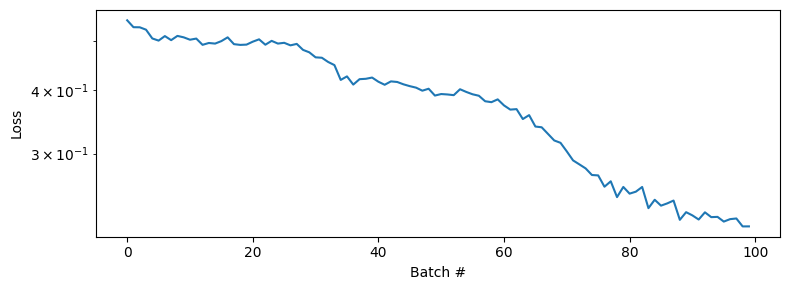

In [6]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  axs.semilogy(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

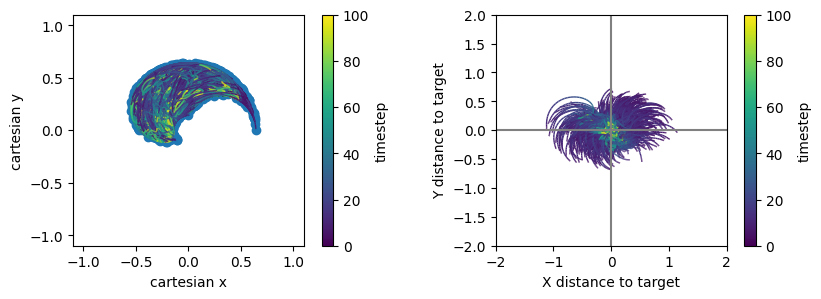

In [7]:
plotor = mn.plotor.plot_pos_over_time

def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.ylim([-1.1, 1.1])
  plt.xlim([-1.1, 1.1])
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plt.ylim([-2, 2])
  plt.xlim([-2, 2])
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()

plot_simulations(xy=th.detach(xy), target_xy=th.detach(tg))